# CMPT 732 - Fall 2022
# Cifar 10 classification

__content creator:__ Aryan Mikaeili

# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets

# Download dataset

In [ ]:
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

batch_size = 128
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=t)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=0)




  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


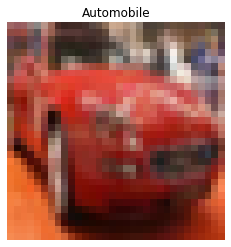

In [ ]:
#plot image from dataset
import matplotlib.pyplot as plt

classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

sample_data = trainset.__getitem__(5)
image, label = sample_data

image = image.permute(1, 2, 0)
image = ((image.numpy() + 1) * 127.5).astype('uint8')


plt.imshow(image)
plt.axis('off')
plt.title(classes[label])
plt.show()

# Define Model

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(BasicBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
  def forward(self, x):
    return self.layers(x)
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.block1 = BasicBlock(3, 16)
    self.block2 = BasicBlock(16, 16)

    self.linear_layers = nn.Sequential(
        nn.Linear(in_features = 5 * 5 * 16, out_features = 128, bias = True),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features = 64, bias = True),
        nn.ReLU(),
        nn.Linear(in_features = 64, out_features = 10, bias = True)
    )
  def forward(self, x):
    out = self.block1(x)
    out = self.block2(out)

    out = out.reshape(-1, 5 * 5 * 16)

    out = self.linear_layers(out)

    return out






# Optimization loop

In [ ]:
nepochs = 10
learning_rate = 1e-3
device = torch.device('cuda')
#define model
model = Classifier().to(device)

#define optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


#define loss
loss_function = nn.CrossEntropyLoss()

#optimization loop
for epoch in range(nepochs):
  total_loss = 0.
  for i, data in enumerate(trainloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    predictions = model(images)
    loss = loss_function(predictions, labels)
    total_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('epoch {}/{}: loss = {:.4f}'.format(epoch, nepochs, total_loss))
  total_loss = 0

epoch 0/10: loss = 659.8333
epoch 1/10: loss = 525.9979
epoch 2/10: loss = 473.6058
epoch 3/10: loss = 438.3493
epoch 4/10: loss = 412.4996
epoch 5/10: loss = 388.9697
epoch 6/10: loss = 373.5695
epoch 7/10: loss = 356.9695
epoch 8/10: loss = 341.4657
epoch 9/10: loss = 330.0541


# Test model

In [ ]:
testset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=t)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=0)


true_count = 0
for i, data in enumerate(testloader):
  images, labels = data
  images = images.to(device)
  labels = labels.to(device)
  
  predictions = model(images)
  prediction_labels = predictions.argmax(dim = 1)
  true_count += (prediction_labels == labels).sum().item()

print('Accuracy = {:.4f}'.format(true_count / testset.__len__()))


Files already downloaded and verified
Accuracy = 0.6626


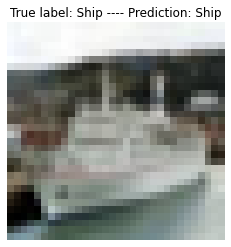

In [ ]:
from matplotlib.cbook import safezip
#plot sample

sample_data = testset.__getitem__(196)
image, label = sample_data
image = image.to(device).unsqueeze(0)

pred = model(image).argmax(dim = 1).item()

image = image.squeeze(0).permute(1, 2, 0).cpu()
image = ((image.numpy() + 1) * 127.5).astype('uint8')

plt.imshow(image)
plt.axis('off')
plt.title('True label: {} ---- Prediction: {}'.format(classes[label], classes[pred]))
plt.show()